### Convolution

이미지로부터 특징을 추출하기 위해서, Convolution 연산을 하는 것이 일반적입니다.

https://insightsimaging.springeropen.com/articles/10.1007/s13244-018-0639-9



pytorch에서는 nn.Conv2d를 통해서 2d 이미지에 대한 Convolution을 할 수 있습니다.

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [ ]:
import torch
import torch.nn as nn

layer = nn.Conv2d(3,6,3)

input_data = torch.rand(20, 3, 100,100)  # 가상 데이터 생성

In [ ]:
input_data.max()

tensor(1.0000)

Conv2d 같은 layer를 만드는 함수는, nn.module을 subclassing 해서 만들어진 것이어서, 바로 모델 처럼 사용도 가능합니다

In [ ]:
output = layer(input_data)

In [ ]:
output.shape

torch.Size([20, 6, 98, 98])

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

summary(layer, (20,3,100,100))

Layer (type:depth-idx)                   Output Shape              Param #
Conv2d                                   [20, 6, 98, 98]           168
Total params: 168
Trainable params: 168
Non-trainable params: 0
Total mult-adds (M): 32.27
Input size (MB): 2.40
Forward/backward pass size (MB): 9.22
Params size (MB): 0.00
Estimated Total Size (MB): 11.62

In [ ]:
layer.weight

Parameter containing:
tensor([[[[ 0.1738, -0.1547,  0.1345],
          [-0.0824, -0.0827,  0.0821],
          [-0.1915, -0.1735, -0.0194]],

         [[-0.0621,  0.1373,  0.0431],
          [-0.1031,  0.1122, -0.0830],
          [-0.0190,  0.1763, -0.1720]],

         [[ 0.0862,  0.0471, -0.1377],
          [ 0.1879, -0.1807, -0.1413],
          [-0.1334, -0.0983,  0.1133]]],


        [[[ 0.0785,  0.0844, -0.0621],
          [-0.0102,  0.0407, -0.1766],
          [-0.0704,  0.1581, -0.0317]],

         [[-0.1691,  0.0167, -0.1869],
          [-0.1096, -0.0729,  0.0172],
          [-0.0061,  0.0369,  0.1906]],

         [[ 0.0984, -0.1642,  0.0135],
          [ 0.1744,  0.1377,  0.1695],
          [ 0.1717,  0.1452, -0.1459]]],


        [[[ 0.0942,  0.1478, -0.1112],
          [-0.0556,  0.0974, -0.1668],
          [-0.1239, -0.0503, -0.0811]],

         [[ 0.1823, -0.0685,  0.0110],
          [ 0.0296, -0.0344,  0.1198],
          [ 0.1545, -0.0506,  0.1619]],

         [[ 0.1567,  0

### cnn 학습을 해보고 convolution에서 이미지가 어떻게 변하는지 살펴봅시다

* 데이터셋은 고양이과 동물 분류로 해보겠습니다.
* https://www.kaggle.com/datasets/gpiosenka/cats-in-the-wild-image-classification

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets
from torchvision.transforms import v2
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

path = '/content/drive/MyDrive/Teaching/PD 2401/wildcats'

transform = v2.Compose([
    v2.ToImage(),# ToTensor와 거의 동일하나, 이미지 데이터라는 구분을 할 수 있는 Image 클래스로 변환
    v2.Resize((112,112)),
    v2.ToDtype(torch.float32, scale=True) ,
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Imagenet 평균값 사용
])

train_data = datasets.ImageFolder(path + '/train', transform = transform)

In [ ]:
train_data[0][0].shape

torch.Size([3, 112, 112])

In [ ]:
# 데이터셋 로드
val_data = datasets.ImageFolder(path + '/valid', transform=transform)

In [ ]:
from torch.utils.data import DataLoader

# DataLoader 설정
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True, num_workers = 2)
val_loader = DataLoader(dataset=val_data, batch_size=64, shuffle=False, num_workers = 2)

In [ ]:
# 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6,12, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(12,24, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(24*13*13, 256),  # 크기 조정
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
model = SimpleCNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
!pip install torchinfo

In [ ]:

from torchinfo import summary

summary(model,(64, 3, 112,112))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [64, 10]                  --
├─Sequential: 1-1                        [64, 24, 13, 13]          --
│    └─Conv2d: 2-1                       [64, 6, 111, 111]         78
│    └─ReLU: 2-2                         [64, 6, 111, 111]         --
│    └─MaxPool2d: 2-3                    [64, 6, 55, 55]           --
│    └─Conv2d: 2-4                       [64, 12, 54, 54]          300
│    └─ReLU: 2-5                         [64, 12, 54, 54]          --
│    └─MaxPool2d: 2-6                    [64, 12, 27, 27]          --
│    └─Conv2d: 2-7                       [64, 24, 26, 26]          1,176
│    └─ReLU: 2-8                         [64, 24, 26, 26]          --
│    └─MaxPool2d: 2-9                    [64, 24, 13, 13]          --
├─Sequential: 1-2                        [64, 10]                  --
│    └─Linear: 2-10                      [64, 256]                 1,038,592
│   

In [ ]:
from tqdm import tqdm

# 학습 함수
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    avg_loss = train_loss / len(train_loader.dataset)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# 검증 함수
def validate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    avg_loss = val_loss / len(val_loader.dataset)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


In [ ]:
# 학습 및 검증 루프
num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, criterion)
    val_loss, val_accuracy = validate(model, device, val_loader, criterion)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')


 10%|█         | 1/10 [00:10<01:36, 10.73s/it]

Epoch 1, Train Loss: 2.2616, Train Accuracy: 14.92%, Val Loss: 2.0890, Val Accuracy: 22.00%



 20%|██        | 2/10 [00:21<01:25, 10.69s/it]

Epoch 2, Train Loss: 1.9860, Train Accuracy: 27.19%, Val Loss: 1.7673, Val Accuracy: 28.00%



 30%|███       | 3/10 [00:31<01:14, 10.64s/it]

Epoch 3, Train Loss: 1.7242, Train Accuracy: 36.47%, Val Loss: 1.5086, Val Accuracy: 46.00%



 40%|████      | 4/10 [00:41<01:00, 10.17s/it]

Epoch 4, Train Loss: 1.5556, Train Accuracy: 42.58%, Val Loss: 1.5040, Val Accuracy: 44.00%



 50%|█████     | 5/10 [00:52<00:51, 10.33s/it]

Epoch 5, Train Loss: 1.4350, Train Accuracy: 46.52%, Val Loss: 1.3802, Val Accuracy: 54.00%



 60%|██████    | 6/10 [01:02<00:41, 10.47s/it]

Epoch 6, Train Loss: 1.3519, Train Accuracy: 51.05%, Val Loss: 1.4005, Val Accuracy: 48.00%



 70%|███████   | 7/10 [01:13<00:31, 10.59s/it]

Epoch 7, Train Loss: 1.2767, Train Accuracy: 52.24%, Val Loss: 1.3606, Val Accuracy: 44.00%



 80%|████████  | 8/10 [01:24<00:21, 10.64s/it]

Epoch 8, Train Loss: 1.2083, Train Accuracy: 56.61%, Val Loss: 1.3669, Val Accuracy: 48.00%



 90%|█████████ | 9/10 [01:33<00:10, 10.31s/it]

Epoch 9, Train Loss: 1.1328, Train Accuracy: 59.26%, Val Loss: 1.3799, Val Accuracy: 46.00%



100%|██████████| 10/10 [01:44<00:00, 10.49s/it]

Epoch 10, Train Loss: 1.0373, Train Accuracy: 62.89%, Val Loss: 1.3528, Val Accuracy: 40.00%


In [ ]:
torch.save(model.state_dict(), path+'/cnn.pt')

conv 연산을 통해서 이미지가 어떻게 변경되는지 살펴봅시다

In [ ]:
conv0 = model.features[0].to('cpu')  # 모델 코드에서 정의된 레이어 지정
relu = model.features[1].to('cpu')
max = model.features[2].to('cpu')
conv1 = model.features[3].to('cpu')



In [ ]:
test_data = datasets.ImageFolder(path + '/test') #transform없이 불러보겠습니다.

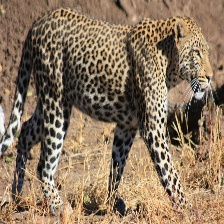

In [ ]:
img = test_data[0][0]
img

In [ ]:
img_tensor = transform(img)

In [ ]:
img_tensor

Image([[[-0.4911, -0.1999, -0.2513,  ...,  0.5364,  0.4508,  0.2282],
        [-0.2513, -0.1143, -0.0629,  ...,  0.5364,  0.4337,  0.0741],
        [ 0.4166,  0.2967,  0.0056,  ...,  0.6221,  0.5536,  0.0056],
        ...,
        [ 0.7419,  0.3309,  0.2282,  ...,  0.2967,  0.9303,  1.1358],
        [ 0.2111,  0.4679,  0.5707,  ...,  0.9303,  1.4612,  1.5125],
        [ 0.0569,  0.0912,  0.5193,  ...,  1.1700,  1.5125,  1.4269]],

       [[-0.6527, -0.4601, -0.5476,  ...,  0.1877,  0.1352, -0.0924],
        [-0.5301, -0.4251, -0.4251,  ...,  0.1702,  0.1001, -0.2500],
        [ 0.0476, -0.0049, -0.2850,  ...,  0.2577,  0.2227, -0.3375],
        ...,
        [ 0.2927, -0.1450, -0.2850,  ..., -0.2850,  0.3102,  0.4853],
        [-0.1450,  0.1001,  0.1352,  ...,  0.2402,  0.7479,  0.8354],
        [-0.1800, -0.3025,  0.1352,  ...,  0.2752,  0.6954,  0.7129]],

       [[-0.7238, -0.5147, -0.6018,  ...,  0.0431, -0.0267, -0.2532],
        [-0.6367, -0.5147, -0.4973,  ...,  0.0256, -0.0441, 

In [ ]:
img_conv0 = conv0(img_tensor)

In [ ]:
img_conv0.shape

torch.Size([6, 111, 111])

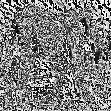

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image

img_conv0_pil = to_pil_image(img_conv0[0])
img_conv0_pil

In [ ]:
img_relu = relu(img_conv0)

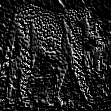

In [ ]:
img_relu_pil = to_pil_image(img_relu[0])
img_relu_pil